In [336]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [378]:
def polytope_activations(model, x, pool_layers=True, cnn_layers=True):
    n = len(x)
    activations = []
    for layer in model.layers:
        if hasattr(layer, 'activation'):
            if not cnn_layers and hasattr(layer, '_name') and 'conv2d' in layer._name:
                x = layer(x)
                continue
            if layer.activation == tf.keras.activations.relu:
                x = layer(x)
                act = (x.numpy() > 0).astype(int).reshape(n, -1)
                activations.append(act)
            elif layer.activation == tf.keras.activations.softmax:
                return activations
#                 act = (x.numpy() > 0.5).astype(int)
#                 activations.append(act)
            else:
                x = layer(x)
        elif pool_layers and hasattr(layer, '_name') and 'max_pooling2d' in layer._name:
            act = tf.nn.max_pool_with_argmax(
                x, layer.pool_size, layer.strides, layer.padding.upper()
            ).argmax.numpy().reshape(n, -1)
            x = layer(x)
            activations.append(act)
        else:
            x = layer(x)

    return np.unique(np.hstack(activations), axis=0, return_inverse=True)[1]

## Cifar

In [368]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [369]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = ['dog', 'cat'] # 3, 5

train_images = train_images[np.where((train_labels == 3) | (train_labels == 5))[0]]
train_labels = train_labels[np.where((train_labels == 3) | (train_labels == 5))[0]]
train_labels = le.fit_transform(train_labels.reshape(-1,))

test_images = test_images[np.where((test_labels == 3) | (test_labels == 5))[0]]
test_labels = test_labels[np.where((test_labels == 3) | (test_labels == 5))[0]]
test_labels = le.transform(test_labels.reshape(-1,))

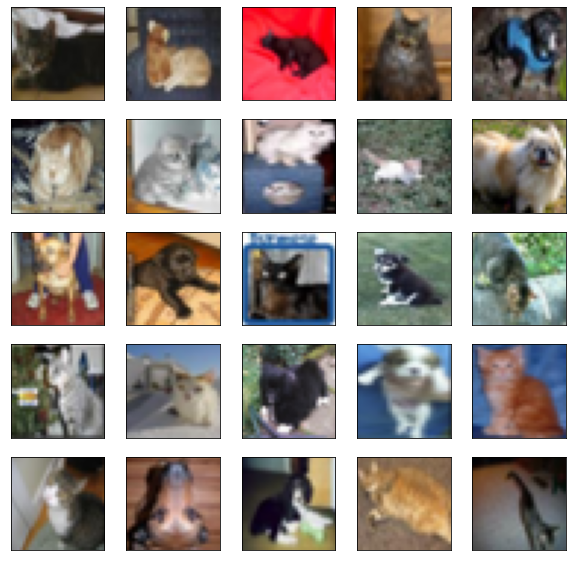

In [370]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    # plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [403]:
def get_model(n_hidden=64, n_filters=None):
    model = models.Sequential()
    model.add(layers.Conv2D(n_filters, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(2*n_filters, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(2*n_filters, (3, 3), activation='relu'))

    model.add(layers.Flatten())#input_shape=(8, 8, 1)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2))
    
    return model
model = get_model(64, 32)

In [404]:
model.summary()

Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_123 (Flatten)        (None, 1024)              0         
_________________________________________________________________
dense_246 (Dense)            (None, 64)             

In [405]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=5, 
                    validation_data=(test_images, test_labels))

Epoch 1/5
313/313 [==============================] - 2s 7ms/step - loss: 0.6818 - accuracy: 0.5529 - val_loss: 0.6257 - val_accuracy: 0.6470
Epoch 2/5
313/313 [==============================] - 2s 6ms/step - loss: 0.6083 - accuracy: 0.6644 - val_loss: 0.5726 - val_accuracy: 0.6990
Epoch 3/5
313/313 [==============================] - 2s 6ms/step - loss: 0.5580 - accuracy: 0.7080 - val_loss: 0.5529 - val_accuracy: 0.7085
Epoch 4/5
313/313 [==============================] - 2s 6ms/step - loss: 0.5201 - accuracy: 0.7464 - val_loss: 0.5160 - val_accuracy: 0.7470
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.4822 - accuracy: 0.7662 - val_loss: 0.4979 - val_accuracy: 0.7530


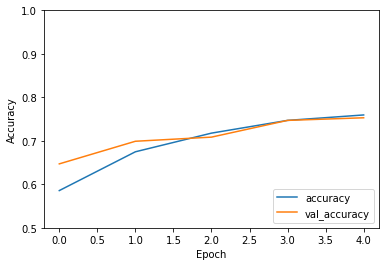

63/63 - 0s - loss: 0.4979 - accuracy: 0.7530
Test Accuracy = 0.753


In [406]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print(f'Test Accuracy = {test_acc:.3f}')

In [409]:
activations = polytope_activations(model, train_images, pool_layers=True, cnn_layers=True)
print('Full model unique regions ' + str(np.unique(activations).shape))

activations = polytope_activations(model, train_images, pool_layers=False, cnn_layers=False)
print('Penulimate unique regions ' + str(np.unique(activations).shape))

Full model unique regions (10000,)
Penulimate unique regions (5233,)


In [396]:
n_hiddens = [64]
n_filters = [1, 2, 4, 8, 16, 32, 64]
n_activated_regions = []
train_accs = []
train_losses = []
test_accs = []
test_losses = []

for n_filter in n_filters:
    model = get_model(n_hiddens[0], n_filters=n_filter)
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    history = model.fit(train_images, train_labels, epochs=5, 
                        validation_data=(test_images, test_labels))
    
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    activations = polytope_activations(model, train_images, pool_layers=False, cnn_layers=False)
    n_activated_regions.append(np.unique(activations).shape[0])

Epoch 1/5
313/313 [==============================] - 4s 12ms/step - loss: 0.6855 - accuracy: 0.5483 - val_loss: 0.6700 - val_accuracy: 0.5805
Epoch 2/5
313/313 [==============================] - 4s 12ms/step - loss: 0.6629 - accuracy: 0.5964 - val_loss: 0.6655 - val_accuracy: 0.5920
Epoch 3/5
313/313 [==============================] - 4s 11ms/step - loss: 0.6601 - accuracy: 0.6010 - val_loss: 0.6618 - val_accuracy: 0.5915
Epoch 4/5
313/313 [==============================] - 4s 12ms/step - loss: 0.6547 - accuracy: 0.6079 - val_loss: 0.6582 - val_accuracy: 0.5965
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.6499 - accuracy: 0.6138
Epoch 1/5
313/313 [==============================] - 4s 13ms/step - loss: 0.6874 - accuracy: 0.5425 - val_loss: 0.6681 - val_accuracy: 0.6150
Epoch 2/5
313/313 [==============================] - 3s 10ms/step - loss: 0.6690 - accuracy: 0.5837 - val_loss: 0.6558 - val_accuracy: 0.6190
Epoch 3/5
313/313 [==============================

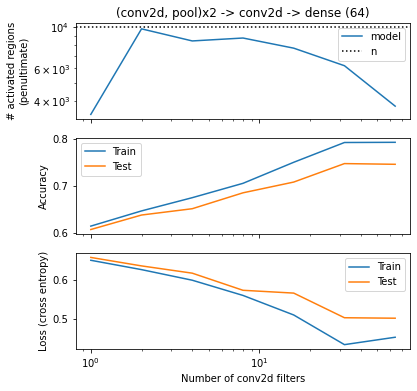

In [415]:
f, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

ax = axes[0]
ax.plot(n_filters, n_activated_regions, label='model')
ax.set_ylabel('# activated regions\n(penultimate)')
ax.axhline(len(train_images), label='n', ls=':', c='black')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title(f'(conv2d, pool)x2 -> conv2d -> dense (64)')


ax = axes[1]
ax.plot(n_filters, train_accs, label='Train')
ax.plot(n_filters, test_accs, label='Test')
ax.set_ylabel('Accuracy')
ax.legend()
# ax.set_yscale('log')
ax.set_xscale('log')

ax = axes[2]
ax.plot(n_filters, train_losses, label='Train')
ax.plot(n_filters, test_losses, label='Test')
ax.set_ylabel('Loss (cross entropy)')
ax.legend()
# ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Number of conv2d filters')
plt.show()

## mini-mnist

In [147]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

In [273]:
digits = datasets.load_digits(n_class=2)

n_samples = len(digits.images)
data = digits.images[..., np.newaxis]

# Split data
train_images, test_images, train_labels, test_labels = train_test_split(
    data, digits.target, test_size=0.1, shuffle=False)

In [357]:
def get_model(n_hidden=64, n_filters=None):
    model = models.Sequential()
    if n_filters is not None:
        model.add(layers.Conv2D(n_filters, (2, 2), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
#         model.add(layers.Conv2D(n_filters, (2, 2), activation='relu'))
#         model.add(layers.MaxPooling2D((2, 2)))
#         model.add(layers.Conv2D(n_filters, (2, 2), activation='relu'))

    model.add(layers.Flatten())#input_shape=(8, 8, 1)))
    model.add(layers.Dense(n_hidden, activation='relu'))
    model.add(layers.Dense(2))
    
    return model

In [348]:
n_hiddens = [4, 8, 16, 32, 48, 64]
n_activated_regions = []

for n_hidden in n_hiddens:
    model = get_model(n_hidden)
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    history = model.fit(train_images, train_labels, epochs=5, 
                        validation_data=(test_images, test_labels))
    
    activations = polytope_activations(model, train_images, pool_layers=True)
    n_activated_regions.append(np.unique(activations).shape[0])

Epoch 1/5
313/313 [==============================] - 1s 4ms/step - loss: 0.7280 - accuracy: 0.4757 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
313/313 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.4849 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
313/313 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5037 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
313/313 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.4901 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.5077 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 1/5
313/313 [==============================] - 1s 3ms/step - loss: 0.7018 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
313/313 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.5066 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
313

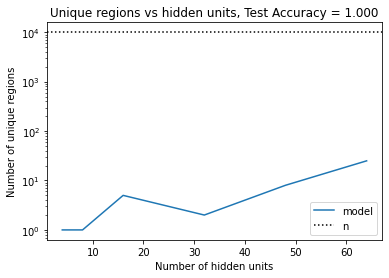

In [350]:
plt.plot(n_hiddens, n_activated_regions, label='model')
plt.ylabel('Number of unique regions')
plt.xlabel('Number of hidden units')
plt.axhline(len(train_images), label='n', ls=':', c='black')
plt.legend()
plt.yscale('log')
plt.title(f'Unique regions vs hidden units, Test Accuracy = {test_acc:.3f}')
plt.show()

In [332]:
n_hiddens = [4, 8, 16, 32, 48, 64]
n_activated_regions = []

for n_hidden in n_hiddens:
    model = get_model(n_hidden, n_filters=1)
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    history = model.fit(train_images, train_labels, epochs=5, 
                        validation_data=(test_images, test_labels))
    
    activations = polytope_activations(model, train_images, pool_layers=True)
    n_activated_regions.append(np.unique(activations).shape[0])

Epoch 1/5
11/11 [==============================] - 0s 14ms/step - loss: 0.9096 - accuracy: 0.4606 - val_loss: 0.6504 - val_accuracy: 0.4722
Epoch 2/5
11/11 [==============================] - 0s 4ms/step - loss: 0.8399 - accuracy: 0.5026 - val_loss: 0.6372 - val_accuracy: 0.4722
Epoch 3/5
11/11 [==============================] - 0s 4ms/step - loss: 0.8471 - accuracy: 0.4703 - val_loss: 0.6232 - val_accuracy: 0.5000
Epoch 4/5
11/11 [==============================] - 0s 4ms/step - loss: 0.7978 - accuracy: 0.5088 - val_loss: 0.6096 - val_accuracy: 0.5000
Epoch 5/5
11/11 [==============================] - 0s 4ms/step - loss: 0.7594 - accuracy: 0.5231 - val_loss: 0.5927 - val_accuracy: 0.5556
Epoch 1/5
11/11 [==============================] - 0s 14ms/step - loss: 2.7514 - accuracy: 0.1268 - val_loss: 2.9764 - val_accuracy: 0.0000e+00
Epoch 2/5
11/11 [==============================] - 0s 4ms/step - loss: 2.1483 - accuracy: 0.1367 - val_loss: 2.3650 - val_accuracy: 0.0000e+00
Epoch 3/5
11/11 [

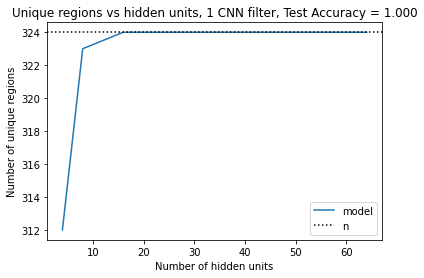

In [333]:
plt.plot(n_hiddens, n_activated_regions, label='model')
plt.ylabel('Number of unique regions')
plt.xlabel('Number of hidden units')
plt.axhline(len(train_images), label='n', ls=':', c='black')
plt.legend()
# plt.xscale('log')
plt.title(f'Unique regions vs hidden units, 1 CNN filter, Test Accuracy = {test_acc:.3f}')
plt.show()

In [358]:
n_hiddens = [8]
n_filters = [1, 2, 3, 4, 5]
n_activated_regions = []

for n_filter in n_filters:
    model = get_model(n_hiddens[0], n_filters=n_filter)
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    history = model.fit(train_images, train_labels, epochs=5, 
                        validation_data=(test_images, test_labels))
    
    activations = polytope_activations(model, train_images, pool_layers=False)
    n_activated_regions.append(np.unique(activations).shape[0])

Epoch 1/5
313/313 [==============================] - 3s 10ms/step - loss: 0.6934 - accuracy: 0.5017 - val_loss: 0.6879 - val_accuracy: 0.5630
Epoch 2/5
313/313 [==============================] - 3s 10ms/step - loss: 0.6828 - accuracy: 0.5668 - val_loss: 0.6644 - val_accuracy: 0.6035
Epoch 3/5
313/313 [==============================] - 3s 9ms/step - loss: 0.6657 - accuracy: 0.6043 - val_loss: 0.6594 - val_accuracy: 0.6055
Epoch 4/5
313/313 [==============================] - 3s 10ms/step - loss: 0.6526 - accuracy: 0.6166 - val_loss: 0.6558 - val_accuracy: 0.6020
Epoch 5/5
313/313 [==============================] - 3s 10ms/step - loss: 0.6471 - accuracy: 0.6278 - val_loss: 0.6543 - val_accuracy: 0.6145
Epoch 1/5
313/313 [==============================] - 3s 8ms/step - loss: 0.6916 - accuracy: 0.5069 - val_loss: 0.6726 - val_accuracy: 0.5770
Epoch 2/5
313/313 [==============================] - 2s 7ms/step - loss: 0.6748 - accuracy: 0.5752 - val_loss: 0.6678 - val_accuracy: 0.6040
Epoch 3/5

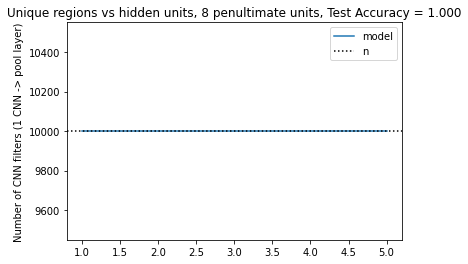

In [359]:
plt.plot(n_filters, n_activated_regions, label='model')
plt.ylabel('Number of unique regions')
plt.ylabel('Number of CNN filters (1 CNN -> pool layer)')
plt.axhline(len(train_images), label='n', ls=':', c='black')
plt.legend()
# plt.xscale('log')
plt.title(f'Unique regions vs hidden units, {n_hiddens[0]} penultimate units, Test Accuracy = {test_acc:.3f}')
plt.show()

In [363]:
activations.shape[0]

10000

In [360]:
n_hiddens = [8]
n_filters = [1, 2, 3, 4, 5]
n_activated_regions = []

for n_filter in n_filters:
    model = get_model(n_hiddens[0], n_filters=n_filter)
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    history = model.fit(train_images, train_labels, epochs=5, 
                        validation_data=(test_images, test_labels))
    
    activations = polytope_activations(model, train_images, pool_layers=False)
    n_activated_regions.append(np.unique(activations).shape[0])

Epoch 1/5
313/313 [==============================] - 3s 10ms/step - loss: 0.6933 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
313/313 [==============================] - 3s 9ms/step - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6915 - val_accuracy: 0.5015
Epoch 3/5
313/313 [==============================] - 3s 9ms/step - loss: 0.6907 - accuracy: 0.5113 - val_loss: 0.6867 - val_accuracy: 0.5465
Epoch 4/5
313/313 [==============================] - 3s 9ms/step - loss: 0.6876 - accuracy: 0.5322 - val_loss: 0.6774 - val_accuracy: 0.5565
Epoch 5/5
313/313 [==============================] - 3s 10ms/step - loss: 0.6826 - accuracy: 0.5578 - val_loss: 0.6709 - val_accuracy: 0.5760
Epoch 1/5
313/313 [==============================] - 3s 8ms/step - loss: 0.6833 - accuracy: 0.5497 - val_loss: 0.6610 - val_accuracy: 0.5940
Epoch 2/5
313/313 [==============================] - 2s 8ms/step - loss: 0.6526 - accuracy: 0.6114 - val_loss: 0.6570 - val_accuracy: 0.6085
Epoch 3/5
3

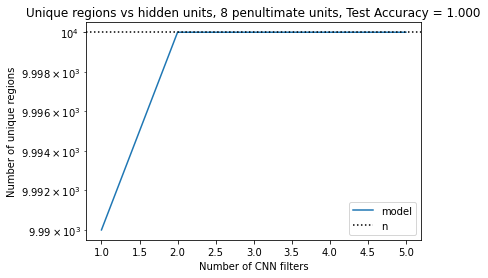

In [367]:
plt.plot(n_filters, n_activated_regions, label='model')
plt.ylabel('Number of unique regions')
plt.xlabel('Number of CNN filters')
plt.axhline(len(train_images), label='n', ls=':', c='black')
plt.legend()
plt.yscale('log')
plt.title(f'Unique regions vs hidden units, {n_hiddens[0]} penultimate units, Test Accuracy = {test_acc:.3f}')
plt.show()

In [291]:
import keras.backend as K

def get_polytope(model, dataset, computeOver=None, batchSize=50):
    layers = []
    
    it = iter(dataset.repeat(-1).shuffle(5000, seed=1).batch(batchSize))
    N = computeOver//batchSize
    batches = [next(it) for i in range(N)]
    polytope_memberships_list = []
    activations_list = []
    for batch in batches:
        batch_ = batch[0]
        
        with tf.GradientTape(persistent=True) as tape:
            intermediateVal = [batch_]
            polytope_memberships = []
            last_activations = batch_
            tape.watch(last_activations)
            for l, layer_ in enumerate(model.layers):
                if l == len(model.layers)-1:
                    break
                preactivation = layer_(last_activations)
                binary_preactivation = K.cast((preactivation > 0), "float")
                if hasattr(layer_, 'activation') and layer_.activation == tf.keras.activations.relu:
                    polytope_memberships.append(binary_preactivation)
                    last_activations = preactivation * binary_preactivation
                else:
                    last_activations = preactivation
            activations_list.append(polytope_memberships)

        polytope_memberships = [
            np.tensordot(
                np.concatenate(polytope_memberships, axis = 1),
                2 ** np.arange(0, np.shape(np.concatenate(polytope_memberships, axis = 1))[1]),
                axes = 1)]
        polytope_memberships_list.append(polytope_memberships[0])
    
    poly_m = np.hstack(polytope_memberships_list)
    return poly_m, activations_list

In [292]:
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

In [293]:
polytopes, activations = get_polytope(model, dataset, len(train_images))

In [294]:
np.unique(polytopes).shape

(192,)

In [302]:
np.asarray(activations).shape

(6, 1, 50, 64)

In [298]:
np.unique(np.vstack(np.squeeze(activations)), axis=0).shape

(196, 64)

In [297]:
np.unique(activations, axis=0).shape

(6, 1, 50, 64)